In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import os
import csv
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import distance_transform_edt

In [76]:
# Process shapes data
raw_shapes = []
directory = 'Dataset/shape'
for file in sorted(os.listdir(directory)):
    filepath = os.path.join(directory, file)
    with open(filepath, newline='') as f:
        reader = csv.reader(f)
        data = list(reader)
        raw_shapes.append(data)

clean_shapes = []
for shape in raw_shapes:
    clean_shape = pd.DataFrame(shape).iloc[1:-1, 1:-2]
    clean_shapes.append(clean_shape.transpose())

# Create signed distance fields for shapes
sdf_shapes = []
for s in clean_shapes:
    # Create a mask for the inside and outside of the shape
    shape = s.astype(float)
    inside_mask = shape == -1
    outside_mask = shape == 0

    # Compute the distance transform for both the inside and outside
    distance_inside = distance_transform_edt(inside_mask)
    distance_outside = distance_transform_edt(outside_mask)

    # Create the signed distance field
    signed_distance_field = distance_outside - distance_inside

    # Normalize the signed distance field
    max_distance = np.max(np.abs(signed_distance_field))
    if max_distance > 0:
        signed_distance_field = signed_distance_field / max_distance

    # Set the values inside the original shape to 0
    signed_distance_field[inside_mask] = 0
    sdf_shapes.append(signed_distance_field)


# Process vertical data
raw_verticals = []
directory = 'Dataset/vertical'
for file in sorted(os.listdir(directory)):
    filepath = os.path.join(directory, file)
    with open(filepath, newline='') as f:
        reader = csv.reader(f)
        data = list(reader)
        raw_verticals.append(data)

clean_verticals = []
for vertical in raw_verticals:
    clean_vertical = pd.DataFrame(vertical).iloc[1:-1, 1:-2]
    clean_verticals.append(clean_vertical.transpose())


# Process horizontal data
raw_horizontals = []
directory = 'Dataset/horizontal'
for file in sorted(os.listdir(directory)):
    filepath = os.path.join(directory, file)
    with open(filepath, newline='') as f:
        reader = csv.reader(f)
        data = list(reader)
        raw_horizontals.append(data)

clean_horizontals = []
for horizontal in raw_horizontals:
    clean_horizontal = pd.DataFrame(horizontal).iloc[1:-1, 1:-2]
    clean_horizontals.append(clean_horizontal.transpose())


# Calculate total velocity
total_velocities = []
for i in range(len(clean_shapes)):
    total_velocity = np.sqrt(np.square(clean_verticals[i].astype(float)) + np.square(clean_horizontals[i].astype(float)))
    total_velocities.append(total_velocity)


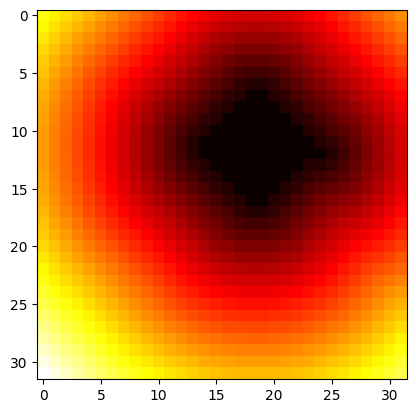

In [77]:
shape_data = sdf_shapes[221].tolist()
shape_data = np.array(shape_data).astype(float)
plt.imshow(shape_data, cmap='hot', interpolation='nearest')
plt.show()

In [78]:
# Create training dataset
temp = []
for i in range(len(sdf_shapes)):
    input_example = sdf_shapes[i].astype(float)
    output_example = total_velocities[i].values.astype(float)
    temp.append((input_example, output_example))

data_tensor = torch.FloatTensor(temp)

# Split training dataset into training, validation, and test
training_size = int(0.6 * len(data_tensor))
validation_size = int(0.2 * len(data_tensor))
test_size = len(data_tensor) - training_size - validation_size

training_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(data_tensor, [training_size, validation_size, test_size])


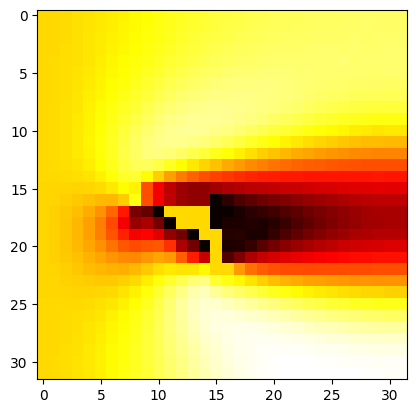

<built-in method type of Tensor object at 0x135f72c30>


In [79]:
input, output = training_dataset[200]
plt.imshow(output, cmap='hot', interpolation='nearest')
plt.show()
print(input.type)

In [80]:
class CFD_CNN(nn.Module):
    def __init__(self):
        super(CFD_CNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.fc = nn.Linear(32, 10)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 2, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [81]:
# Initialize the model
model = CFD_CNN()
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

In [82]:
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for data in training_dataset:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        tensor_inputs = torch.FloatTensor(inputs).reshape(1, 1, 32, 32)
        tensor_labels = torch.FloatTensor(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(tensor_inputs)
        loss = criterion(outputs, tensor_labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        print('[%d] loss: %.3f' % (epoch + 1, running_loss / len(training_dataset)))
          

print('Finished Training')

[1] loss: 0.002
[1] loss: 0.003
[1] loss: 0.004
[1] loss: 0.005
[1] loss: 0.007
[1] loss: 0.008
[1] loss: 0.009
[1] loss: 0.010
[1] loss: 0.010
[1] loss: 0.010
[1] loss: 0.011
[1] loss: 0.011
[1] loss: 0.011
[1] loss: 0.012
[1] loss: 0.012
[1] loss: 0.013
[1] loss: 0.013
[1] loss: 0.013
[1] loss: 0.013
[1] loss: 0.014
[1] loss: 0.014
[1] loss: 0.014
[1] loss: 0.015
[1] loss: 0.015
[1] loss: 0.015
[1] loss: 0.016
[1] loss: 0.016
[1] loss: 0.016
[1] loss: 0.016
[1] loss: 0.017
[1] loss: 0.017
[1] loss: 0.017
[1] loss: 0.018
[1] loss: 0.018
[1] loss: 0.018
[1] loss: 0.018
[1] loss: 0.019
[1] loss: 0.019
[1] loss: 0.019
[1] loss: 0.020
[1] loss: 0.020
[1] loss: 0.020
[1] loss: 0.020
[1] loss: 0.021
[1] loss: 0.021
[1] loss: 0.021
[1] loss: 0.021
[1] loss: 0.022
[1] loss: 0.022
[1] loss: 0.022
[1] loss: 0.022
[1] loss: 0.023
[1] loss: 0.023
[1] loss: 0.023
[1] loss: 0.023


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 32])) that is different to the input size (torch.Size([1, 2, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1] loss: 0.024
[1] loss: 0.024
[1] loss: 0.024
[1] loss: 0.024
[1] loss: 0.025
[1] loss: 0.025
[1] loss: 0.025
[1] loss: 0.025
[1] loss: 0.026
[1] loss: 0.026
[1] loss: 0.026
[1] loss: 0.026
[1] loss: 0.027
[1] loss: 0.027
[1] loss: 0.027
[1] loss: 0.027
[1] loss: 0.028
[1] loss: 0.028
[1] loss: 0.028
[1] loss: 0.028
[1] loss: 0.029
[1] loss: 0.029
[1] loss: 0.029
[1] loss: 0.030
[1] loss: 0.030
[1] loss: 0.030
[1] loss: 0.030
[1] loss: 0.030
[1] loss: 0.030
[1] loss: 0.031
[1] loss: 0.031
[1] loss: 0.031
[1] loss: 0.031
[1] loss: 0.031
[1] loss: 0.032
[1] loss: 0.032
[1] loss: 0.032
[1] loss: 0.032
[1] loss: 0.032
[1] loss: 0.033
[1] loss: 0.033
[1] loss: 0.033
[1] loss: 0.033
[1] loss: 0.033
[1] loss: 0.033
[1] loss: 0.034
[1] loss: 0.034
[1] loss: 0.034
[1] loss: 0.034
[1] loss: 0.035
[1] loss: 0.035
[1] loss: 0.035
[1] loss: 0.035
[1] loss: 0.035
[1] loss: 0.035
[1] loss: 0.036
[1] loss: 0.036
[1] loss: 0.036
[1] loss: 0.036
[1] loss: 0.037
[1] loss: 0.037
[1] loss: 0.037
[1] loss

torch.Size([1, 2, 32, 32])


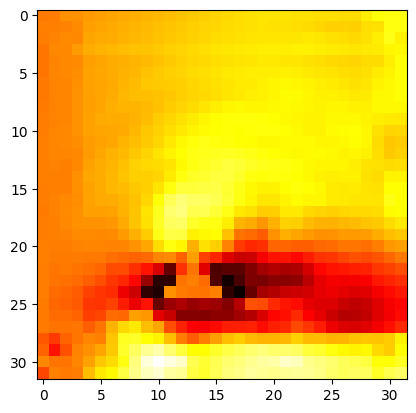

<built-in method type of Tensor object at 0x135f72c30>
-0.06766751408576965


In [83]:
inputs, labels = test_dataset[40]
tensor_inputs = torch.FloatTensor(inputs).reshape(1, 1, 32, 32)
tensor_labels = torch.FloatTensor(labels)

tensor_outputs = model(tensor_inputs)

print(tensor_outputs.shape)

plt.imshow(tensor_outputs[0][1].detach().numpy(), cmap='hot', interpolation='nearest')
plt.show()
print(input.type)
print(np.amin(tensor_outputs[0][1].tolist()))



torch.Size([32, 32])


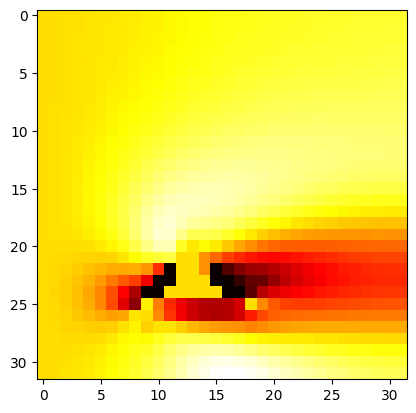

0.0


In [84]:
print(tensor_labels.shape)
plt.imshow(tensor_labels.detach().numpy(), cmap='hot', interpolation='nearest')
plt.show()
print(np.amin(tensor_labels.detach().numpy().tolist()))

torch.Size([1, 1, 32, 32])


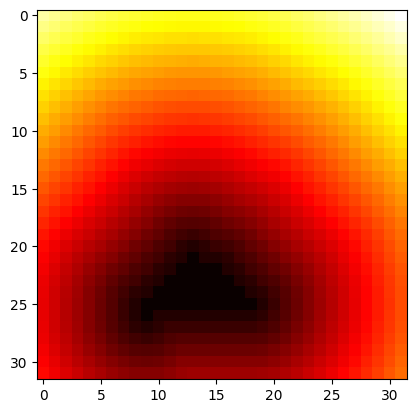

In [85]:
print(tensor_inputs.shape)
plt.imshow(tensor_inputs[0][0].detach().numpy(), cmap='hot', interpolation='nearest')
plt.show()

In [86]:
total_mse = 0

for data in test_dataset:
    inputs, labels = data
    tensor_inputs = torch.FloatTensor(inputs).reshape(1, 1, 32, 32)
    tensor_labels = torch.FloatTensor(labels)

    tensor_outputs = model(tensor_inputs)

    predicted = tensor_outputs[0][1].detach().numpy()
    actual = tensor_labels.detach().numpy()

    mse = np.mean((actual - predicted) ** 2)
    total_mse += mse

accuracy = (total_mse / len(test_dataset)) * 100
print(f"Accuracy: {accuracy}%")

Accuracy: 1.5425489195622504%
